# Brain tumor detector with transfer learning with MobileNetV2

This notebook illustrates how deep learning can be used in the real world to classify images of brain MRI scans and predict whether they contain tumors or not.

Transfer Learning is efficient when the size of the dataset is small, thus, in this case it may be used to create a better model. 

The dataset used in this notebook is taken from Navoneel Chakrabarty's public kaggle dataset 'Brain MRI Images for Brain Tumor Detection' which can be accessed using the link - https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

# Importing Required Packages

In [4]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
import os
import PIL

Fixing image size and batch size

In [5]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
dirname = os.getcwd()
filename = os.path.join(dirname, 'Tumour Dataset')
path = filename

# Generating the training and validation datasets

In [6]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = path, 
                                                                 batch_size = BATCH_SIZE, 
                                                                 image_size = IMAGE_SIZE, 
                                                                 seed = 10, 
                                                                 validation_split = 0.2, 
                                                                 subset = 'training', 
                                                                 label_mode = 'categorical')

Found 253 files belonging to 2 classes.
Using 203 files for training.


In [7]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(directory = path, 
                                                                 batch_size = BATCH_SIZE, 
                                                                 image_size = IMAGE_SIZE, 
                                                                 seed = 10, 
                                                                 validation_split = 0.2, 
                                                                 subset = 'validation', 
                                                                 label_mode = 'categorical')

Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [8]:
class_names = training_ds.class_names
print(class_names)

['no', 'yes']


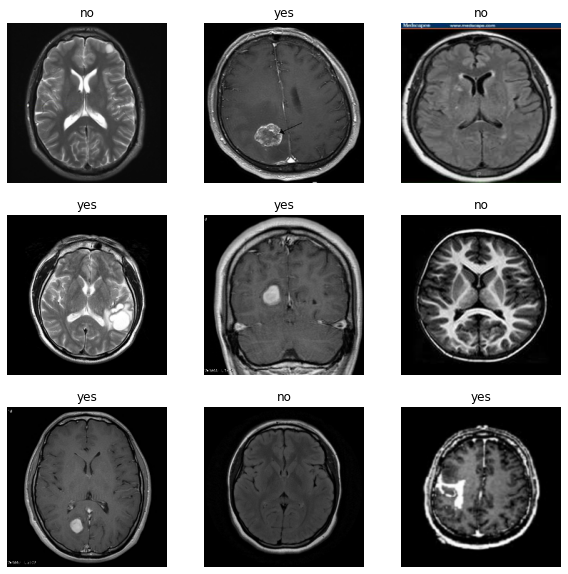

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in training_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 2)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
training_ds = training_ds.prefetch(buffer_size = AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size = AUTOTUNE)

# Creating the Model

In [12]:
IMAGE_SHAPE = IMAGE_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(weights = 'imagenet', include_top = False)
x = base_model.output
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dense(200)(x)
x = tfl.Activation('relu')(x)
x = tfl.Dropout(0.2)(x)
x = tfl.Dense(100)(x)
x = tfl.Activation('relu')(x)
x = tfl.Dropout(0.2)(x)
x = tfl.Dense(2, activation = 'softmax')(x)

In [13]:
model = tf.keras.Model(inputs = base_model.input, outputs = x)

In [14]:
for layer in model.layers:
    layer.trainable=False

for layer in model.layers[-8:]:
    layer.trainable=True

In [15]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
history = model.fit(training_ds, validation_data = validation_ds, epochs = 10, batch_size = 32)

Epoch 1/10
7/7 [==============================] - 32s 3s/step - loss: 0.7887 - accuracy: 0.5665 - val_loss: 0.5412 - val_accuracy: 0.7200
Epoch 2/10
7/7 [==============================] - 19s 3s/step - loss: 0.5038 - accuracy: 0.7389 - val_loss: 0.4534 - val_accuracy: 0.7800
Epoch 3/10
7/7 [==============================] - 18s 2s/step - loss: 0.4573 - accuracy: 0.7685 - val_loss: 0.3792 - val_accuracy: 0.8600
Epoch 4/10
7/7 [==============================] - 17s 2s/step - loss: 0.3994 - accuracy: 0.8522 - val_loss: 0.4062 - val_accuracy: 0.7400
Epoch 5/10
7/7 [==============================] - 18s 3s/step - loss: 0.3820 - accuracy: 0.8473 - val_loss: 0.4123 - val_accuracy: 0.8200
Epoch 6/10
7/7 [==============================] - 20s 3s/step - loss: 0.3352 - accuracy: 0.8670 - val_loss: 0.3388 - val_accuracy: 0.9200
Epoch 7/10
7/7 [==============================] - 19s 3s/step - loss: 0.2986 - accuracy: 0.8768 - val_loss: 0.3314 - val_accuracy: 0.9000
Epoch 8/10
7/7 [==================

In [17]:
model.save('Brain Tumor Detector Model.h5')

c:\program files\python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


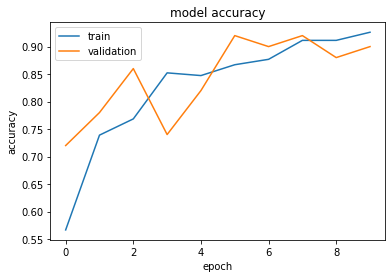

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

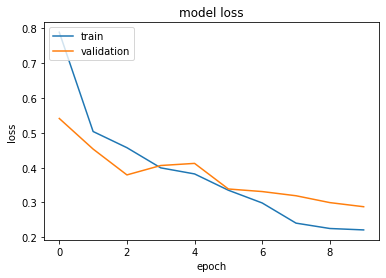

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
test_image_folder = os.path.join(dirname, 'Test Images')
img_path = os.path.join(test_image_folder, 'normal1.jpeg')
img = tf.keras.preprocessing.image.load_img(img_path, target_size = IMAGE_SIZE)
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
img_test = img/255.0

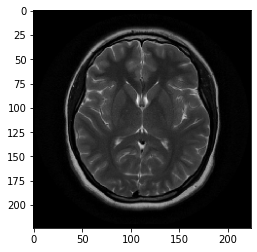

healthy brain!


In [21]:
pred = model.predict(img)
plt.imshow(img_test[0])
plt.show()
if np.argmax(pred) == 0:
    print('healthy brain!')
else:
    print('tumour detected')